In [1]:
import json
import pandas as pd

with open('../Datasets/train.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)

In [2]:
train_data = pd.DataFrame(json_data)
train_data = train_data.drop(['tags', 'plylst_title', 'updt_date'], axis=1)
train_data.head()

,id,songs,like_cnt
0,61281,"[525514, 129701, 383374, 562083, 297861, 13954...",71
1,10532,"[432406, 675945, 497066, 120377, 389529, 24427...",1
2,76951,"[83116, 276692, 166267, 186301, 354465, 256598...",17
3,147456,"[394031, 195524, 540149, 287984, 440773, 10033...",33
4,27616,"[159327, 553610, 5130, 645103, 294435, 100657,...",9


In [3]:
train_data = train_data.explode('songs')
train_data.head()

,id,songs,like_cnt
0,61281,525514,71
0,61281,129701,71
0,61281,383374,71
0,61281,562083,71
0,61281,297861,71


In [4]:
train_data.rename(columns={'songs':'song_id', 'id':'plylst_id'}, inplace=True)
train_data.head()

,plylst_id,song_id,like_cnt
0,61281,525514,71
0,61281,129701,71
0,61281,383374,71
0,61281,562083,71
0,61281,297861,71


In [5]:
with open('../Datasets/song_meta.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)

In [6]:
song_data = pd.DataFrame(json_data)
song_data = song_data.drop(['issue_date', 'album_id', 'artist_id_basket', 'album_name', 'artist_name_basket', 'song_gn_gnr_basket'], axis=1)
song_data.rename(columns={'id':'song_id', 'song_gn_dtl_gnr_basket':'dtl_gnr'}, inplace=True)
song_data.head()

,dtl_gnr,song_name,song_id
0,[GN0901],Feelings,0
1,"[GN1601, GN1606]","Bach : Partita No. 4 In D Major, BWV 828 - II....",1
2,[GN0901],Solsbury Hill (Remastered 2002),2
3,"[GN1102, GN1101]",Feeling Right (Everything Is Nice) (Feat. Popc...,3
4,"[GN1802, GN1801]",그남자 그여자,4


In [7]:
genre_list = []

for l in song_data['dtl_gnr']:
    temp = dict()
    g = 0
    mx = 0
    
    for i in l:
        i = i[2:]
        n = int(i) // 100
        if n in temp:
            temp[n] += 1
        else:
            temp[n] = 1
    
    for i in temp:
        if mx < temp[i]:
            g = i
            mx = temp[i]
        elif mx == temp[i] and g > i:
            g = i
        
    genre_list.append(g)

song_data['dtl_gnr'] = genre_list
song_data.head()

,dtl_gnr,song_name,song_id
0,9,Feelings,0
1,16,"Bach : Partita No. 4 In D Major, BWV 828 - II....",1
2,9,Solsbury Hill (Remastered 2002),2
3,11,Feeling Right (Everything Is Nice) (Feat. Popc...,3
4,18,그남자 그여자,4


In [8]:
merge = pd.merge(train_data, song_data)
merge.head(30)

,plylst_id,song_id,like_cnt,dtl_gnr,song_name
0,61281,525514,71,14,Hey Little Girl
1,122798,525514,285,14,Hey Little Girl
2,76836,525514,8,14,Hey Little Girl
3,117966,525514,902,14,Hey Little Girl
4,19623,525514,1,14,Hey Little Girl
5,10853,525514,10,14,Hey Little Girl
6,94159,525514,132,14,Hey Little Girl
7,61281,129701,71,9,Octagon
8,122798,129701,285,9,Octagon
9,145788,129701,24,9,Octagon


# 전처리 고려사항
- Missing Value : 각 Attribute 별 N/A 가 존재하는지 확인
- Outlier : like_cnt (좋아요 개수)의 특이 케이스
- 불균형 데이터 : 특정 노래가 다수의 플레이리스트에 동시에 존재하는 경우 고려

# Missing Value 탐색
- Missing Value 가 존재하지 않아 그에 따른 전처리는 진행하지 않았음

In [9]:
print(merge.isnull().sum())

plylst_id    0
song_id      0
like_cnt     0
dtl_gnr      0
song_name    0
dtype: int64


# Outlier 탐색

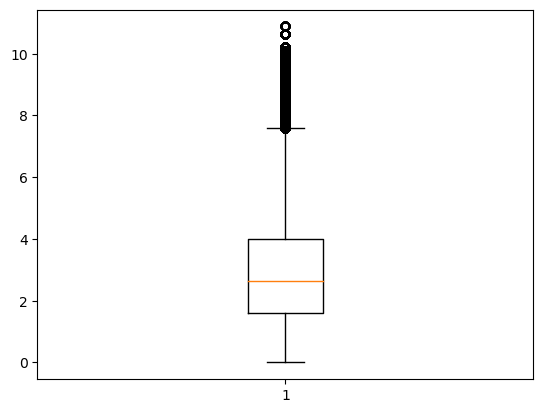

Q1: 4.0 / Q3: 48.0 / Median: 12.0
Mean: 175.56776319361558
Std: 904.199306203648


In [10]:
import matplotlib.pyplot as plt
import numpy as np

merge_log = np.log([x for x in merge['like_cnt'] if x != 0])
plt.boxplot(merge_log)
plt.show()

sorted_like_cnt = np.sort(merge['like_cnt'])
Q1 = np.percentile(sorted_like_cnt, 25)
Q3 = np.percentile(sorted_like_cnt, 75)
median = np.median(sorted_like_cnt)
print("Q1: {} / Q3: {} / Median: {}".format(Q1, Q3, median))
print("Mean: {}".format(merge['like_cnt'].mean()))
print("Std: {}".format(merge['like_cnt'].std()))

# Outlier 처리 - Drop
- 위에서 발생한 이상치는 '인기있는 플레이리스트' 라는 신뢰성 있는 정보이므로 사실 데이터를 삭제하는 것은 신뢰성을 떨어뜨릴 수 있음
- 하지만 여기에서는 다양한 전처리 기법을 사용하는데 의의가 있으므로 코드로 구현.

In [11]:
iqr_min = Q1 - 1.5*(Q3-Q1)
iqr_max = Q3 + 1.5*(Q3-Q1)

outlier_drop = merge[(merge['like_cnt'] >= iqr_min) & (merge['like_cnt'] <= iqr_max)]
outlier_drop.head(20)

,plylst_id,song_id,like_cnt,dtl_gnr,song_name
0,61281,525514,71,14,Hey Little Girl
2,76836,525514,8,14,Hey Little Girl
4,19623,525514,1,14,Hey Little Girl
5,10853,525514,10,14,Hey Little Girl
7,61281,129701,71,9,Octagon
9,145788,129701,24,9,Octagon
10,61281,383374,71,10,The Road
11,61281,562083,71,9,Honeymoon
12,17297,562083,12,9,Honeymoon
13,57947,562083,8,9,Honeymoon


# Outlier 처리 - Replace
- like_cnt 가 매우 크다는 것은 오류가 있는 데이터가 아니므로, 삭제 대신 상한값으로 대체
- 이 때 상한값은 Q3 를 기준으로 설정

In [12]:
merge.head(20)

,plylst_id,song_id,like_cnt,dtl_gnr,song_name
0,61281,525514,71,14,Hey Little Girl
1,122798,525514,285,14,Hey Little Girl
2,76836,525514,8,14,Hey Little Girl
3,117966,525514,902,14,Hey Little Girl
4,19623,525514,1,14,Hey Little Girl
5,10853,525514,10,14,Hey Little Girl
6,94159,525514,132,14,Hey Little Girl
7,61281,129701,71,9,Octagon
8,122798,129701,285,9,Octagon
9,145788,129701,24,9,Octagon


In [13]:
outlier_replace = merge.copy()
outlier_replace['like_cnt'] = outlier_replace['like_cnt'].clip(0, Q3)
outlier_replace.head(20)

,plylst_id,song_id,like_cnt,dtl_gnr,song_name
0,61281,525514,48,14,Hey Little Girl
1,122798,525514,48,14,Hey Little Girl
2,76836,525514,8,14,Hey Little Girl
3,117966,525514,48,14,Hey Little Girl
4,19623,525514,1,14,Hey Little Girl
5,10853,525514,10,14,Hey Little Girl
6,94159,525514,48,14,Hey Little Girl
7,61281,129701,48,9,Octagon
8,122798,129701,48,9,Octagon
9,145788,129701,24,9,Octagon


# Outlier 처리 - Scaling
- 데이터가 표준정규분포를 따르도록 만들기 위해 Z-Score 정규화를 적용
- MinMax Scaling 의 경우 값이 0~1 사이로 정해지며 Regression 모델에 적합하기 때문에 여기서는 사용하지 않음

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

scaler = ColumnTransformer(transformers=[('scaler', StandardScaler(), ['like_cnt'])], remainder='passthrough')
transformed_scaler = scaler.fit_transform(merge)
outlier_scale = pd.DataFrame(transformed_scaler, columns=merge.columns)
outlier_scale.rename(columns={'plylst_id':'like_cnt', 'song_id':'plylst_id', 'like_cnt':'song_id'}, inplace=True)
outlier_scale.head(20)

,like_cnt,plylst_id,song_id,dtl_gnr,song_name
0,-0.115647,61281,525514,14,Hey Little Girl
1,0.121027,122798,525514,14,Hey Little Girl
2,-0.185322,76836,525514,14,Hey Little Girl
3,0.803398,117966,525514,14,Hey Little Girl
4,-0.193063,19623,525514,14,Hey Little Girl
5,-0.18311,10853,525514,14,Hey Little Girl
6,-0.048184,94159,525514,14,Hey Little Girl
7,-0.115647,61281,129701,9,Octagon
8,0.121027,122798,129701,9,Octagon
9,-0.167627,145788,129701,9,Octagon


# 불균형 데이터 탐색
- 특정 플레이리스트에 속한 음악들의 개수
- 특정 음악이 다수의 플레이리스트에 속한 경우
- 특정 장르의 음악들의 개수

In [15]:
merge.groupby('plylst_id').size()

plylst_id
1          5
2         16
4         31
5         22
6         85
          ..
153423    20
153425    29
153426    26
153427    20
153428    50
Length: 115071, dtype: int64

In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter

y = merge['dtl_gnr']
X = merge.drop(['dtl_gnr', 'song_name'], axis=1)
X_resampled, y_resampled = SMOTE().fit_resample(X,y)
print(Counter(y))
print(Counter(y_resampled))

Counter({1: 967285, 9: 490074, 5: 474976, 25: 446893, 3: 376092, 4: 314617, 11: 309442, 13: 221832, 18: 212464, 12: 198532, 15: 191933, 10: 177120, 2: 156626, 6: 151219, 17: 146708, 16: 100714, 19: 61784, 8: 52458, 14: 45601, 21: 39628, 7: 36678, 22: 30820, 26: 24383, 27: 19426, 20: 19354, 0: 11423, 28: 3366, 24: 3353, 23: 1070})
Counter({14: 967285, 9: 967285, 10: 967285, 13: 967285, 19: 967285, 11: 967285, 1: 967285, 6: 967285, 5: 967285, 17: 967285, 18: 967285, 16: 967285, 26: 967285, 15: 967285, 4: 967285, 3: 967285, 8: 967285, 7: 967285, 25: 967285, 2: 967285, 12: 967285, 20: 967285, 27: 967285, 0: 967285, 22: 967285, 21: 967285, 28: 967285, 24: 967285, 23: 967285})


# Memory Error 방지를 위한 데이터 제거 작업

In [18]:
filter_merge = merge[merge['like_cnt'] >= merge['like_cnt'].mean()]
print(merge.shape)
print(filter_merge.shape)

(5285871, 5)
(721409, 5)


In [36]:
import surprise
from surprise import Dataset, Reader, KNNBaseline
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader(rating_scale=(0.5, 5))
df = pd.DataFrame(filter_merge, columns=['plylst_id', 'song_id', 'like_cnt'])
train_fold = Dataset.load_from_df(df[['plylst_id', 'song_id', 'like_cnt']], reader = reader)

tr, te = train_test_split(train_fold, test_size=.25, random_state=42)
#train_df = train_fold.build_full_trainset()

sim_options = {'name':'cosine'}
algo = surprise.KNNBasic(sim_option=sim_options)
algo.fit(tr)
#trainset = train_folds.build_full_trainset()

#res = algo.get_neighbors(5, k=5)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [37]:
pred = algo.test(te)
accuracy.rmse(pred)

RMSE: 2489.4534


2489.4534065611515

In [14]:
train_target.head()

0     61281
1    122798
2     76836
3    117966
4     19623
Name: id, dtype: int64

In [15]:
from sklearn.neighbors import KNeighborsClassifier 
kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(train_src, train_target)
print(kn.score(train_src, train_target))

0.6098291085802132


In [16]:
with open('../Datasets/test.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)

In [17]:
test_data = pd.DataFrame(json_data)
test_data = test_data.drop(['tags', 'plylst_title', 'updt_date'], axis=1)
test_data.head()

,id,songs,like_cnt
0,70107,"[398985, 449403, 411543, 528044, 143048, 98020...",6
1,7461,"[196298, 269984, 267805, 175867, 529244, 63825...",0
2,90348,"[273433, 331003, 68432, 411659, 117793, 616860...",21
3,58617,"[702227, 48152, 440008, 358488, 701041, 540721...",0
4,102395,"[630683, 481582, 528550, 285114, 506667, 17922...",38


In [18]:
test_data.rename(columns={'songs':'song_id'}, inplace=True)
test_data.head()

,id,song_id,like_cnt
0,70107,"[398985, 449403, 411543, 528044, 143048, 98020...",6
1,7461,"[196298, 269984, 267805, 175867, 529244, 63825...",0
2,90348,"[273433, 331003, 68432, 411659, 117793, 616860...",21
3,58617,"[702227, 48152, 440008, 358488, 701041, 540721...",0
4,102395,"[630683, 481582, 528550, 285114, 506667, 17922...",38


각 노래가 가장 맞다고 생각하는 train data의 플레이리스트 배정

주어진 플레이리스트의 노래가 train data의 어떤 플레이리스트에 맞는지 판단하여 어떤 플레이리스트와 유사한지 확인

가장 유사한 플레이리스트부터 기존 플레이리스트에 존재하지 않는 노래를 30개 이내로 추출 후 추천

In [24]:
import numpy as np

for ti in test_data['id']:
    test_temp = test_data[test_data['id'] == ti]
    
    test_temp = test_temp.explode('song_id')
    
    test_temp_merge = pd.merge(test_temp, song_all)
    test_src = test_temp_merge.drop(['id', 'artist_id_basket'], axis=1)
    
    if test_src.empty:
        continue
    
    id_list = kn.predict(test_src)
    
    id_nums = dict()
    
    for i in id_list:
        if i in id_nums:
            id_nums[i] += 1
        else:
            id_nums[i] = 1
    
    ids = sorted(id_nums.items(), key=lambda x: x[1], reverse=True)
    ids_index = 0
    cnt = 0
    
    recommend = []
    
    while cnt < 30 and len(ids) > ids_index:
        for song in train_data[train_data['id']==ids[ids_index][0]]['song_id']:
            if not song in test_temp['song_id'] and not song in recommend:
                recommend.append(song)
                cnt += 1
            
            if cnt == 30:
                break
        
        ids_index += 1
    
    print(recommend)

[559041, 347303, 695910, 394079, 472395, 705682, 346913, 534183, 199134, 377279, 227169, 205149, 89571, 426348, 45581, 621133, 316600, 190352, 305064, 225247, 513270, 628459, 618150, 271922, 549815, 528044, 2479, 510258, 466272, 167278]
[273697, 11862, 580388, 238725, 698920, 455322, 616335, 371964, 341371, 223083, 28091, 155282, 490373, 386945, 68488, 81311, 290571, 285721, 400853, 491059, 589293, 493450, 328858, 504565, 649290, 61064, 216584, 225897, 637781, 241816]
[588746, 679096, 547940, 409613, 194542, 505019, 173681, 333091, 331003, 509484, 589292, 34880, 308966, 425889, 68432, 397412, 615960, 61595, 42792, 679429, 277441, 703596, 277728, 325909, 341775, 579797, 637476, 652747, 641003, 107276]
[232336, 503993, 229349, 6270, 653835, 175944, 65261, 669010, 648959, 361955, 401499, 657700, 168689, 397869, 369328, 183343, 8719, 556926, 328502, 365790, 271190, 19399, 474012, 465524, 203225, 463069, 628206, 358876, 432191, 603698]
[423098, 77620, 449446, 464392, 683909, 380626, 627603,

KeyboardInterrupt: 